In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
#import xgboost as XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier  # Example model
from scipy.stats import randint  # For random distribution options
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,classification_report,confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# 1 upload file
from google.colab import files
uploaded = files.upload()
original_df=pd.read_csv('BreastCancerData.csv')
# count the NA values in the array
pd.isnull(original_df).sum(axis=0)

Saving BreastCancerData.csv to BreastCancerData.csv


,0
id,0
diagnosis,0
radius_mean,0
texture_mean,0
perimeter_mean,0
area_mean,0
smoothness_mean,0
compactness_mean,0
concavity_mean,0
concave_points_mean,0


In [3]:
# 1.1 generate df
df=original_df.drop(['id'],axis=1)

In [4]:
"""
plt.figure(figsize=(30, 10))
for i, feature in enumerate (df.columns,1):
    plt.subplot(4,11,i)
    sns.histplot((df[df['diagnosis'] == 'M'])[feature], color='#E74C3C', alpha=0.5, kde=True)
    sns.histplot((df[df['diagnosis'] == 'B'])[feature], color='#12436D', alpha=0.5, kde=True)
    plt.title(f'Distribute {feature}')
plt.tight_layout()
plt.show()
"""

"\nplt.figure(figsize=(30, 10))\nfor i, feature in enumerate (df.columns,1):\n    plt.subplot(4,11,i)\n    sns.histplot((df[df['diagnosis'] == 'M'])[feature], color='#E74C3C', alpha=0.5, kde=True)\n    sns.histplot((df[df['diagnosis'] == 'B'])[feature], color='#12436D', alpha=0.5, kde=True)\n    plt.title(f'Distribute {feature}')\nplt.tight_layout()\nplt.show()\n"

In [5]:
# 2 get equal amount for M&B
m=(original_df['diagnosis']=="M").sum() # malignant
b=(original_df['diagnosis']=="B").sum() # benign
# to get equail amount of control vs malignant
sample_size = max(0, b - m)
# Drop the rows after sampling
df.drop(df[original_df['diagnosis'] == "M"].sample(n=sample_size, random_state=0).index, inplace=True)
y_colname='diagnosis'

In [6]:
df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [7]:
df['p1'] = (df['perimeter_mean'] ** 2) / (4 * np.pi) - (np.pi * df['radius_mean'] ** 2)
df['p2'] = (df['perimeter_se'] ** 2) / (4 * np.pi) - (np.pi * df['radius_se'] ** 2)
df['p3'] = (df['perimeter_worst'] ** 2) / (4 * np.pi) - (np.pi * df['radius_worst'] ** 2)
# PCA reduction
pca = PCA(n_components=3)
df['c1'] = pca.fit_transform(df[['compactness_worst','concavity_worst','compactness_mean','concavity_mean']])[:, 0]
df['c2'] = pca.fit_transform(df[['perimeter_worst', 'radius_worst','area_worst','area_mean','radius_mean','perimeter_mean']])[:, 0]
df['c3'] = pca.fit_transform(df[['concave_points_worst', 'concave_points_mean','p1','p3']])[:, 0]
df['c4'] = pca.fit_transform(df[['fractal_dimension_worst', 'fractal_dimension_mean','fractal_dimension_se','concave_points_worst','compactness_se','concavity_se']])[:, 0]
df['c11'] = pca.fit_transform(df[['compactness_worst','concavity_worst','compactness_mean','concavity_mean']])[:, 1]
df['c12'] = pca.fit_transform(df[['perimeter_worst', 'radius_worst','area_worst','area_mean','radius_mean','perimeter_mean']])[:, 1]
df['diagnosis'] = df['diagnosis'].replace(('B','M'),(0,1))
"""
matrix = df.corr()
sns.clustermap(matrix, annot=True, cmap="coolwarm", figsize=(24, 20))
plt.show()
"""

'\nmatrix = df.corr()\nsns.clustermap(matrix, annot=True, cmap="coolwarm", figsize=(24, 20))\nplt.show()\n'

In [8]:
# according to the observation above:
# 1 mean of radius, perimeter, radius_worst, and perimeter_worst columns are dropped due to redundant
# 2 many columns, like symmetry-se, (low corelation) weak corelated columns are dropped
# 3 drop those columns with the same information (take a guess), like just keep one in area_mean and area_worst
#df=df[['diagnosis', 'area_mean', 'concavity_mean', 'concave_points_mean','perimeter_se', 'area_se',
#      'concave_points_se', 'area_worst', 'compactness_worst', 'concavity_worst','concave_points_worst']]

In [9]:
ds=df[['radius_worst', 'area_worst', 'perimeter_worst', 'radius_mean',y_colname]]

In [10]:
# reduce to 16 for GXBoost
ds=df[['perimeter_worst', 'concavity_worst', 'area_mean', 'concavity_se', 'concave_points_worst', 'area_worst', 'texture_se', 'smoothness_se', 'radius_worst', 'concave_points_mean', 'compactness_mean', 'smoothness_mean', 'radius_se', 'radius_mean', 'concavity_mean', 'symmetry_mean',y_colname]]

In [11]:
ds=df[['perimeter_worst', 'concavity_worst', 'area_mean', 'concavity_se', y_colname]]

In [12]:
# reduce to 9 for random forest
ds=df[['radius_worst','perimeter_worst','area_worst','concave_points_worst',y_colname]]

In [13]:
# reduce to 16 for random forest
ds=df[['area_worst','perimeter_worst','radius_worst','concave_points_mean',y_colname]]

In [14]:
# without engineered
ds=df[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst', y_colname]]

In [15]:
# with engineered
ds=df

In [16]:
X=ds.drop("diagnosis", axis=1)
y=ds.diagnosis

In [17]:
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(exclude=['float64', 'int64']).columns
# scale X & y
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X[numeric_cols])
X[numeric_cols] = X_scaled
# If y is a pandas Series or DataFrame, use .values to get the numpy array
# If y is already a numpy array, use it directly
if isinstance(y, (pd.Series, pd.DataFrame)): y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()
elif isinstance(y, np.ndarray): y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()
#y = pd.DataFrame({y_colname: y})
# get back the column names
def apply_feature_group_types(df, feature_groups):
    column_type_mapping = {}
    # Assuming feature_groups is a list of dictionaries:
    for group in feature_groups:  # Iterate through each group in the list
        # Check if the group is a dictionary and has the necessary keys
        if isinstance(group, dict) and 'group_name' in group and 'columns' in group:
            group_name = group['group_name']
            columns = group['columns']
            for column in columns:
                if column in X.columns:
                    column_type_mapping[column] = data_types.get(column)
    df = df.astype(column_type_mapping)
    return df
# Apply the types

print("null",df.isnull().sum().sum(),"; inf",df.isin([np.inf, -np.inf]).sum().sum(),"; X shape",X.shape,'; y shape',y.shape,end='')

null 0 ; inf 0 ; X shape (424, 39) ; y shape (424,)

In [18]:
X_train,X_test,y_train,y_test = train_test_split(ds.drop("diagnosis", axis=1),
                                                 ds.diagnosis,
                                                 test_size= 1/4,
                                                 random_state=0,
                                                 stratify= ds.diagnosis)

In [19]:
#scaler = StandardScaler()
#data_scalered= scaler.fit_transform(X_train);X_train = pd.DataFrame(data_scalered, columns=X_train.columns)
#data_scalered= scaler.fit_transform(X_test);X_test = pd.DataFrame(data_scalered, columns=X_test.columns)

In [20]:
# Define the model
model = RandomForestClassifier(random_state=0)
"""
# Hyperparameter grid for RandomForestClassifier
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=0),
    param_grid_rf,
    cv=5,
    scoring='accuracy'  # Change the scoring metric for classification
)
grid_rf.fit(X_train, y_train)
model1=RandomForestClassifier(**grid_rf.best_params_,
            random_state=0)
"""

model1=RandomForestClassifier(
    bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200,
            random_state=0)

model1.fit(X_train, y_train)
predicciones = model1.predict(X_test)
# Define the parameter distribution
#parametros = {
#    'n_estimators': [100],  # Increased max number of trees
#    'max_depth': [12],   # More depth options
#    'min_samples_split': [5, 10],   # Adjust split criteria
#    'min_samples_leaf': [2, 4],      # More leaf options
#    'max_features': ['sqrt', 'log2', 0.5], # Add a float option for feature selection
#    'bootstrap': [True, False]              # Keep bootstrap options
#}

# Configure the randomized search with cross-validation
#randomized_search_cv = RandomizedSearchCV(**grid_rf.best_params_,
#            random_state=0)

# Train the model
#RF_class = randomized_search_cv.fit(X_train, y_train)

# Print the best hyperparameters found
#print("Mejores hiperparámetros encontrados:")
#print(randomized_search_cv.best_params_)

# Use the best model to make predictions
#mejor_modelo = RF_class.best_estimator_
#predicciones = mejor_modelo.predict(X_test)

In [21]:
#grid_rf.best_params_

In [22]:
test_acc = accuracy_score(y_test, predicciones)
test_f1 = f1_score(y_test, predicciones,  average = 'weighted')
test_recall = recall_score(y_test, predicciones,   average = 'weighted')
test_precision1 = precision_score(y_test , predicciones, average = 'weighted')
print("Resultados RandomForest")
print(f"ACC = {test_acc}")
print(f"F1 = {test_f1}")
print(f"Recall = {test_recall}")
print(f"Precision = {test_precision1}")

Resultados RandomForest
ACC = 1.0
F1 = 1.0
Recall = 1.0
Precision = 1.0


In [23]:
print("RandomForest Results")
print(classification_report(y_test, predicciones))

RandomForest Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       1.00      1.00      1.00        17

    accuracy                           1.00       106
   macro avg       1.00      1.00      1.00       106
weighted avg       1.00      1.00      1.00       106



                         Importance
concave_points_worst       0.104604
perimeter_worst            0.094203
area_worst                 0.086425
concave_points_mean        0.086100
radius_worst               0.078830
p1                         0.071616
perimeter_mean             0.052586
c2                         0.043065
c4                         0.042703
area_se                    0.035278
concavity_mean             0.031395
radius_mean                0.023673
area_mean                  0.022323
c11                        0.018761
texture_worst              0.016128
c1                         0.014291
c12                        0.014205
symmetry_worst             0.013974
smoothness_worst           0.013247
compactness_worst          0.012927
perimeter_se               0.012534
texture_mean               0.010959
c3                         0.010447
fractal_dimension_se       0.008771
compactness_mean           0.008697
radius_se                  0.007485
fractal_dimension_worst    0

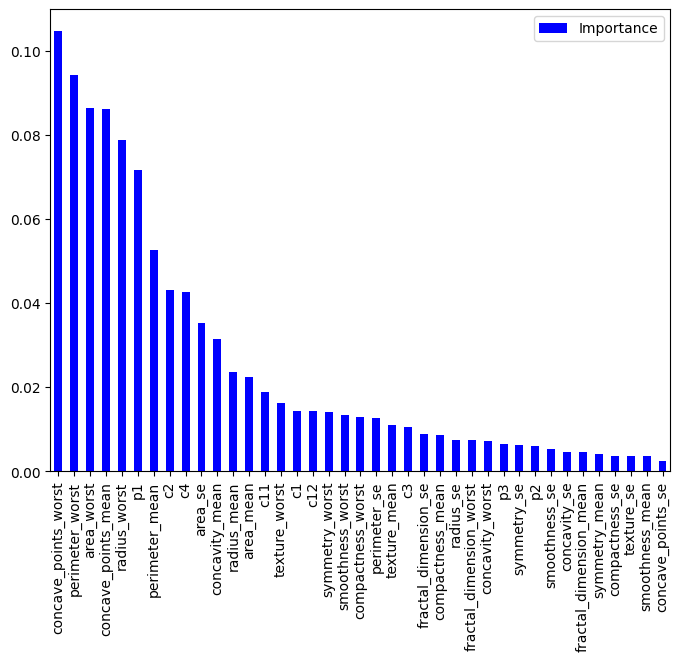

In [24]:
def get_importances (mejor_modelo, X_train):
    feat_importances = pd.DataFrame(mejor_modelo.feature_importances_, index = X_train.columns, columns = ["Importance"])
    feat_importances.sort_values(by = "Importance", ascending = False, inplace = True)
    feat_importances.plot(kind = "bar", color = "blue", figsize = (8,6))
    print(feat_importances)

get_importances(model1,X_train)

In [25]:
scores = cross_val_score(model1, X_test, y_test, cv=5, scoring='accuracy')  # Puedes cambiar 'accuracy' por otra métrica
print(f"Cross-Validation Accuracy Scores: {scores}")
print(f"Mean Accuracy: {scores.mean()}")

Cross-Validation Accuracy Scores: [1.        0.9047619 1.        1.        1.       ]
Mean Accuracy: 0.980952380952381


In [26]:
class_counts = np.bincount(y_train)
class_weight = class_counts[0] / class_counts[1]

In [27]:
#model2 = GridSearchCV.XGBClassifier(use_label_encoder=False,scale_pos_weight=class_weight, eval_metric='logloss')
# parameter
#params = {
#    'booster': 'gbtree',
#    'max_depth': 6,
#    'learning_rate': 0.1,
#    'n_estimators': 100,
#    'subsample': 0.8,
#    'colsample_bytree': 0.8,
#    'objective': 'binary:logistic',
#    'eval_metric': 'logloss'
#}
"""
# Hyperparameter grid for XGBClassifier
gparam_rid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_xgb = GridSearchCV(XGBClassifier(random_state=0, enable_categorical=True),
                        gparam_rid_xgb, cv=5, scoring='neg_mean_squared_error')
grid_xgb.fit(X_train, y_train)

model2=XGBClassifier(
            **grid_xgb.best_params_,
            random_state=0,
            enable_categorical=True)
"""

model2 = XGBClassifier(
    colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.6,
    random_state=0,
    enable_categorical=True
)

model2.fit(X_train, y_train)
test_pred2 = model2.predict(X_test)

In [28]:
#grid_xgb.best_params_

In [29]:
test_acc = accuracy_score(y_test, test_pred2)
test_f1 = f1_score(y_test, test_pred2,  average = 'weighted')
test_recall = recall_score(y_test, test_pred2,   average = 'weighted')
test_precision2 = precision_score(y_test , test_pred2, average = 'weighted')
print("XGBoostClassifier Results")
print(f"ACC = {test_acc}")
print(f"F1 = {test_f1}")
print(f"Recall = {test_recall}")
print(f"Precision = {test_precision2}")

XGBoostClassifier Results
ACC = 1.0
F1 = 1.0
Recall = 1.0
Precision = 1.0


                         Importance
p1                         0.161956
perimeter_worst            0.128380
concave_points_worst       0.093441
c2                         0.081786
area_worst                 0.061625
area_mean                  0.061458
area_se                    0.034493
radius_worst               0.030572
radius_se                  0.025534
concavity_worst            0.022656
perimeter_se               0.022114
c4                         0.021976
texture_worst              0.020017
compactness_mean           0.019800
p3                         0.018523
concave_points_mean        0.018197
radius_mean                0.016822
fractal_dimension_mean     0.015885
texture_mean               0.014320
concavity_mean             0.011881
c12                        0.011848
symmetry_worst             0.011344
c1                         0.011335
smoothness_worst           0.011307
fractal_dimension_se       0.010896
smoothness_mean            0.010806
concavity_se               0

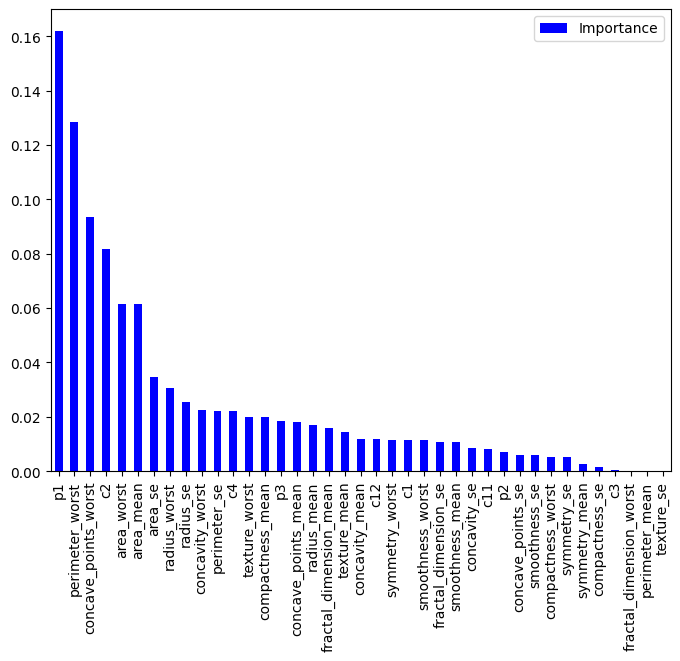

In [30]:
get_importances(model2,X_train)

In [31]:
scores = cross_val_score(model2, X_test, y_test, cv=5, scoring='accuracy')  # Puedes cambiar 'accuracy' por otra métrica
print(f"Cross-Validation Accuracy Scores: {scores}")
print(f"Mean Accuracy: {scores.mean()}")

Cross-Validation Accuracy Scores: [1.         0.85714286 1.         0.95238095 1.        ]
Mean Accuracy: 0.9619047619047618


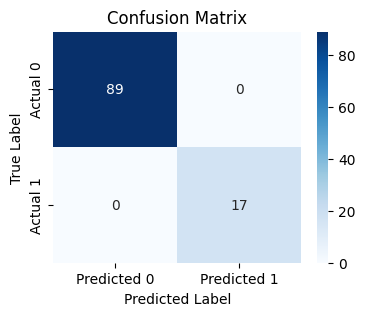

In [32]:
y_pred = model2.predict(X_test)
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [33]:
#with open('RF_class.pkl', 'wb') as file:
#    pickle.dump(mejor_modelo, file)

In [34]:
#with open("RF_class.pkl", "rb") as file:
#    mejor_modelo = pickle.load(file)

In [35]:
#inputs = X_test.iloc[:,:].values.tolist()
# [
#df.iloc[0:1,1:].values[0].tolist(),
#df.iloc[2:3,1:].values[0].tolist()
#]
#[17.99,10.38,1001,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871],
#[20.57,17.77,1326,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667]

In [36]:
"""# Confusion Matrix
plt.figure(figsize=(15, 7))
for i, (model, y_pred) in enumerate(zip([model, model2], [test_pred,test_pred2])):
  # Use the index (i) for the subplot number
  cm = confusion_matrix(y_test, y_pred)
  plt.subplot(2, 4, i+1 )  # Start from 1
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title(f'Confusion Matrix for {model.__class__.__name__}'); plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.show()"""

"# Confusion Matrix\nplt.figure(figsize=(15, 7))\nfor i, (model, y_pred) in enumerate(zip([model, model2], [test_pred,test_pred2])):\n  # Use the index (i) for the subplot number\n  cm = confusion_matrix(y_test, y_pred)\n  plt.subplot(2, 4, i+1 )  # Start from 1\n  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')\n  plt.title(f'Confusion Matrix for {model.__class__.__name__}'); plt.xlabel('Predicted'); plt.ylabel('Actual')\nplt.tight_layout()\nplt.show()"

In [37]:
"""predicciones = mejor_modelo.predict(inputs)
for i, pred in enumerate(predicciones):
    print(f"Input {i+1}: {inputs[i]} -> Predicción: {pred}")"""

'predicciones = mejor_modelo.predict(inputs)\nfor i, pred in enumerate(predicciones):\n    print(f"Input {i+1}: {inputs[i]} -> Predicción: {pred}")'

In [38]:
"""# Obtener las probabilidades en lugar de predicciones crudas
predicciones = mejor_modelo.predict_proba(inputs)

for i, pred in enumerate(predicciones):
    clase_predicha = pred.argmax()
    # if clase_predicha ==  1:
    #     clase_predicha_str = 'Non demented'
    # else:
    #     clase_predicha_str = "Demented"

    probabilidad = pred[clase_predicha] * 100

    print(f"Input {i+1}: Prediction Class: {clase_predicha}, veracity: {probabilidad:.2f}%")"""

'# Obtener las probabilidades en lugar de predicciones crudas\npredicciones = mejor_modelo.predict_proba(inputs)\n\nfor i, pred in enumerate(predicciones):\n    clase_predicha = pred.argmax()\n    # if clase_predicha ==  1:\n    #     clase_predicha_str = \'Non demented\'\n    # else:\n    #     clase_predicha_str = "Demented"\n\n    probabilidad = pred[clase_predicha] * 100\n\n    print(f"Input {i+1}: Prediction Class: {clase_predicha}, veracity: {probabilidad:.2f}%")'

In [39]:
#predicciones.mean(axis=0)

In [40]:
"""ds=np.array(df);y=ds[:,0:1];ds=ds[:,1:];
pca_c = PCA();pca_c.fit(ds);
cumulative_variance = np.cumsum(pca_c.explained_variance_ratio_)
# Perform PCA for n_components=2
pca = PCA(n_components=2);scaler = StandardScaler();X_pca = pca.fit_transform(scaler.fit_transform(df))
# Create side by side plots
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns for side by side
# Left plot: Cumulative Explained Variance
ax1.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
# Right plot: PCA result
scatter1 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=100)
ax1.set_title('Cumulative Explained Variance')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Cumulative Explained Variance')
ax1.set_xticks(range(1, len(cumulative_variance) + 1))
ax1.axhline(y=0.9, color='r', linestyle='--')  # Reference line for 90%
ax1.grid(True)
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_title('PCA of Disease vs Control Data')
ax2.grid(True)
# Add colorbar for the right plot
fig1.colorbar(scatter1, ax=ax2, label='Group (0 = Control, 1 = Disease)')
# Show the figure
plt.tight_layout()
plt.show()
# Get the PCA loadings
loadings = pca.components_.T;np.round(loadings,decimals=4)"""

"ds=np.array(df);y=ds[:,0:1];ds=ds[:,1:];\npca_c = PCA();pca_c.fit(ds);\ncumulative_variance = np.cumsum(pca_c.explained_variance_ratio_)\n# Perform PCA for n_components=2\npca = PCA(n_components=2);scaler = StandardScaler();X_pca = pca.fit_transform(scaler.fit_transform(df))\n# Create side by side plots\nfig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns for side by side\n# Left plot: Cumulative Explained Variance\nax1.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')\n# Right plot: PCA result\nscatter1 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=100)\nax1.set_title('Cumulative Explained Variance')\nax1.set_xlabel('Principal Component')\nax1.set_ylabel('Cumulative Explained Variance')\nax1.set_xticks(range(1, len(cumulative_variance) + 1))\nax1.axhline(y=0.9, color='r', linestyle='--')  # Reference line for 90%\nax1.grid(True)\nax2.set_xlabel('Principal Component 1')\nax2.set_ylabel('